In [28]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import xarray as xr
from pathlib import Path

### load the landsat data [30m] from Jan 6 to Jan 11

In [10]:
landsat_gdf = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/sat_data/DL_FIRE_LS_580312/fire_nrt_LS_580312.shp")

In [24]:
la_bounds = {
    "minx": -118.7, "maxx": -118.0,  # Longitude range
    "miny": 33.7, "maxy": 34.3       # Latitude range
}

# Filter the dataset to keep only the region of LA
landsat_gdf_la = landsat_gdf.cx[la_bounds["minx"]:la_bounds["maxx"], la_bounds["miny"]:la_bounds["maxy"]]

### Clip to fire perimeter

In [33]:
fire_perimeter = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/fires_perimeter.geojson")
fire_perimeter

mission_group  OBJECTID                              GlobalID  \
0         Eaton      1269  ea6b6983-73b6-49fa-b467-1081579fb284   
1     Palisades      1264  0bc1ddb3-63bf-4fd8-a01b-d522f57e4083   

             type source        poly_DateCurrent                mission  \
0  Heat Perimeter  FIRIS 2025-01-09 02:29:10.844      CA-LAC-EATON-N57B   
1  Heat Perimeter  FIRIS 2025-01-07 23:17:39.000  CA-LFD-PALISADES-N57B   

  incident_name                       incident_number    area_acres  ...  \
0         Eaton  72660adc-b5ef-4d96-a33f-b4ea3740a4e3  10589.956010  ...   
1     Palisades                                         1261.520779  ...   

  PercentPerimToBeContained ModifiedBySystem2 sourceoid  \
0                      None              None      None   
1                      None              None      None   

                              websiteId websiteDbId  \
0  dbfa574e-1b10-4467-b5e5-7d1c06ebc8dc        4319   
1  abfed7a3-794a-4294-9852-43176dcbc18a        4318   

                            dataverseId displayStatus Shape__Area  \
0  2b91dbc1-79cd-ef11-b8e9-001dd804aa64      Inactive    0.004192   
1  f0a2f70e-2dcd-ef11-b8e9-001dd804aa64        Active    0.000499   

  Shape__Length                                           geometry  
0      0.818015  MULTIPOLYGON (((-118.15647 34.18125, -118.1564...  
1      0.342099  MULTIPOLYGON (((-118.56728 34.04256, -118.5672...  

[2 rows x 36 columns]

In [35]:
landsat_gdf_la = landsat_gdf_la.to_crs(fire_perimeter.crs)

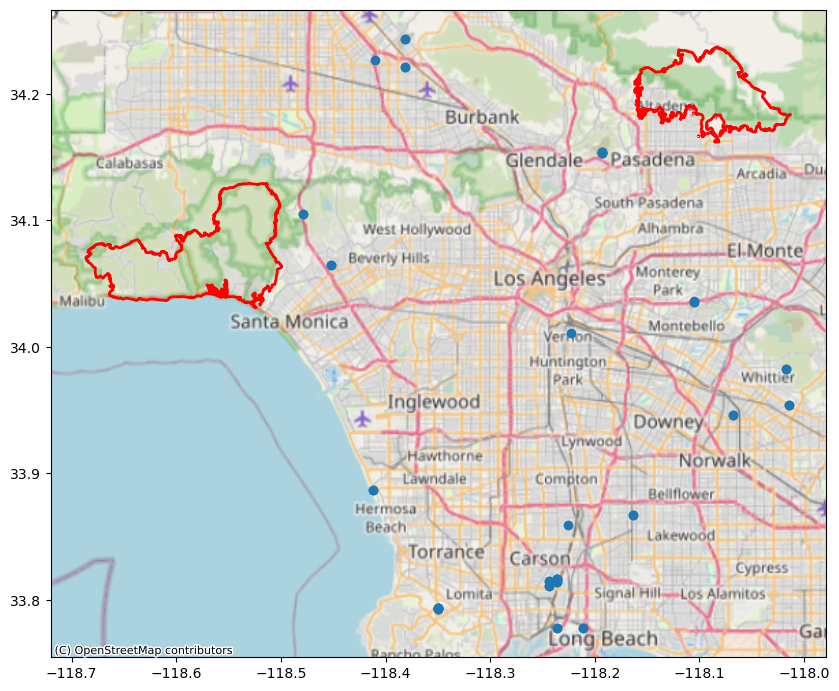

In [65]:
f,ax=plt.subplots(figsize=(10,10))

landsat_gdf_la.plot(ax=ax)
gpd.GeoSeries(fire_perimeter.geometry).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)

#### Ops, no data from landsat
### load the MODIS data [1KM] from Jan 6 to Jan 11

In [37]:
modis_gdf = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/sat_data/DL_FIRE_M-C61_580311/fire_nrt_M-C61_580311.shp")

In [39]:
# Filter the dataset to keep only the region of LA
modis_gdf_la = modis_gdf.cx[la_bounds["minx"]:la_bounds["maxx"], la_bounds["miny"]:la_bounds["maxy"]]

In [40]:
modis_gdf_la = modis_gdf_la.to_crs(fire_perimeter.crs)

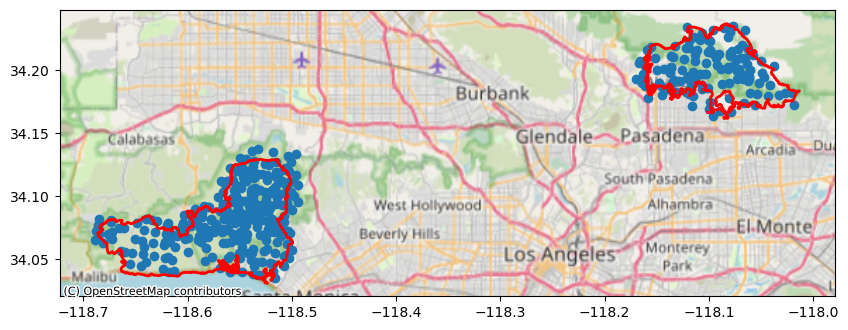

In [64]:
f,ax=plt.subplots(figsize=(10,10))

modis_gdf_la.plot(ax=ax)
gpd.GeoSeries(fire_perimeter.geometry).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)

In [43]:
modis_eaton = modis_gdf_la.clip(fire_perimeter.geometry.iloc[0])
modis_palisades = modis_gdf_la.clip(fire_perimeter.geometry.iloc[1])

### load the S-NPP VIIRS data [375 M] from Jan 6 to Jan 11

In [47]:
sv_gdf = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/sat_data/DL_FIRE_SV-C2_580315/fire_nrt_SV-C2_580315.shp")

In [49]:
# Filter the dataset to keep only the region of LA
sv_gdf_la = sv_gdf.cx[la_bounds["minx"]:la_bounds["maxx"], la_bounds["miny"]:la_bounds["maxy"]]

In [50]:
sv_gdf_la = sv_gdf_la.to_crs(fire_perimeter.crs)

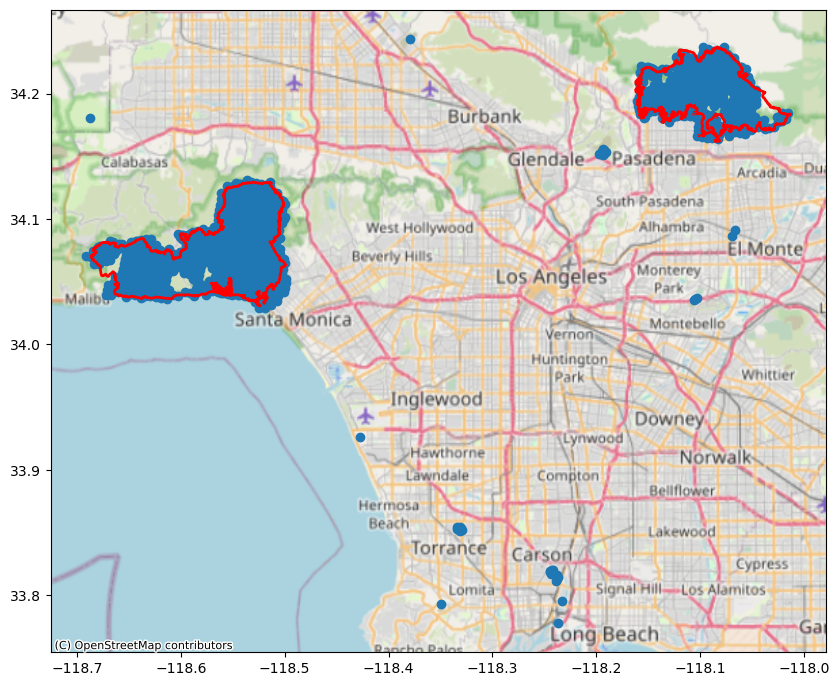

In [51]:
f,ax=plt.subplots(figsize=(10,10))

sv_gdf_la.plot(ax=ax)
gpd.GeoSeries(fire_perimeter.geometry).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=landsat_gdf_la.crs)

In [52]:
sv_eaton = sv_gdf_la.clip(fire_perimeter.geometry.iloc[0])
sv_palisades = sv_gdf_la.clip(fire_perimeter.geometry.iloc[1])

### load the JPSS NOAA-20 VIIRS data [375 M] from Jan 6 to Jan 11

In [53]:
j1_gdf = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/sat_data/DL_FIRE_J1V-C2_580313/fire_nrt_J1V-C2_580313.shp")

In [55]:
# Filter the dataset to keep only the region of LA
j1_gdf_la = j1_gdf.cx[la_bounds["minx"]:la_bounds["maxx"], la_bounds["miny"]:la_bounds["maxy"]]

In [57]:
j1_gdf_la = j1_gdf_la.to_crs(fire_perimeter.crs)

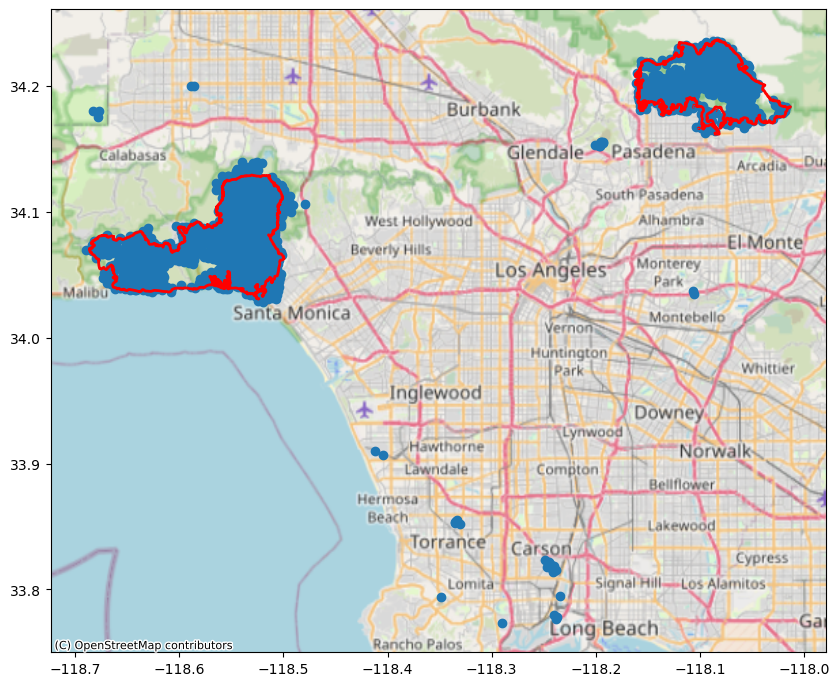

In [63]:
f,ax=plt.subplots(figsize=(10,10))

j1_gdf_la.plot(ax=ax)
gpd.GeoSeries(fire_perimeter.geometry).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)

In [59]:
j1_eaton = j1_gdf_la.clip(fire_perimeter.geometry.iloc[0])
j1_palisades = j1_gdf_la.clip(fire_perimeter.geometry.iloc[1])

### load the JPSS NOAA-21 VIIRS data [375 M] from Jan 6 to Jan 11

In [60]:
j2_gdf = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/sat_data/DL_FIRE_J2V-C2_580314/fire_nrt_J2V-C2_580314.shp")

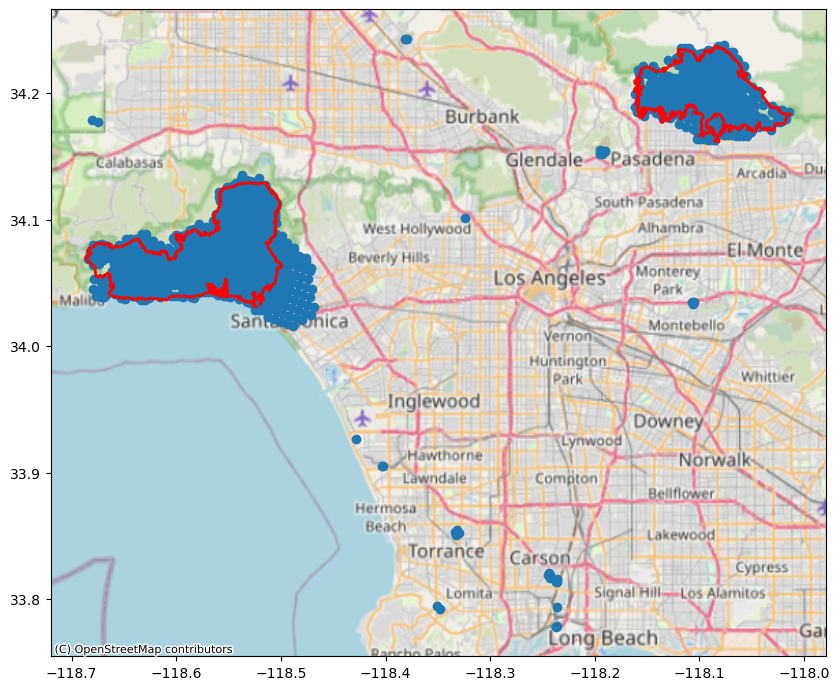

In [62]:
# Filter the dataset to keep only the region of LA
j2_gdf_la = j2_gdf.cx[la_bounds["minx"]:la_bounds["maxx"], la_bounds["miny"]:la_bounds["maxy"]]

j2_gdf_la = j2_gdf_la.to_crs(fire_perimeter.crs)

f,ax=plt.subplots(figsize=(10,10))

j2_gdf_la.plot(ax=ax)
gpd.GeoSeries(fire_perimeter.geometry).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)

In [66]:
j2_eaton = j2_gdf_la.clip(fire_perimeter.geometry.iloc[0])
j2_palisades = j2_gdf_la.clip(fire_perimeter.geometry.iloc[1])

## Merge all available data to one dataset for each region

In [81]:
for gdf in [j1_eaton, j1_palisades, j2_eaton, j2_palisades, modis_eaton, modis_palisades, sv_eaton, sv_palisades]:
    gdf.loc[:, "ACQ_DATE"] = pd.to_datetime(gdf["ACQ_DATE"])

In [82]:
merged_eaton_gdf = gpd.GeoDataFrame(pd.concat([j1_eaton, j2_eaton, modis_eaton, sv_eaton], ignore_index=True))
merged_palisades_gdf = gpd.GeoDataFrame(pd.concat([j1_palisades, j2_palisades, modis_palisades, sv_palisades], ignore_index=True))

# Sort by time
merged_eaton_gdf = merged_eaton_gdf.sort_values(by="ACQ_DATE").reset_index(drop=True)
merged_palisades_gdf = merged_palisades_gdf.sort_values(by="ACQ_DATE").reset_index(drop=True)

#### Visualize the daily change

In [89]:
merged_eaton_gdf

LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME  \
0     34.16967 -118.09380      325.84  0.42   0.37 2025-01-08     0949   
1     34.19470 -118.09840      329.94  0.34   0.56 2025-01-08     0902   
2     34.19506 -118.10323      318.00  0.34   0.56 2025-01-08     0902   
3     34.19533 -118.10707      322.28  0.34   0.56 2025-01-08     0902   
4     34.19534 -118.09283      316.01  0.62   0.71 2025-01-08     1042   
...        ...        ...         ...   ...    ...        ...      ...   
1552  34.22037 -118.06968      300.23  0.39   0.36 2025-01-11     0945   
1553  34.22103 -118.07374      296.04  0.39   0.36 2025-01-11     0945   
1554  34.22567 -118.08121      298.02  0.39   0.36 2025-01-11     0945   
1555  34.22830 -118.07646      295.37  0.39   0.36 2025-01-11     0945   
1556  34.20324 -118.07168      298.24  0.39   0.36 2025-01-11     0945   

     SATELLITE INSTRUMENT CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  \
0          N20      VIIRS          n  2.0NRT      286.16  4.48        N   
1          N21      VIIRS          n  2.0NRT      284.40  4.80        N   
2          N21      VIIRS          n  2.0NRT      284.62  8.76        N   
3          N21      VIIRS          n  2.0NRT      283.97  8.76        N   
4          N21      VIIRS          n  2.0NRT      277.71  3.65        N   
...        ...        ...        ...     ...         ...   ...      ...   
1552       N21      VIIRS          n  2.0NRT      281.87  0.74        N   
1553       N21      VIIRS          n  2.0NRT      283.04  0.74        N   
1554       N21      VIIRS          n  2.0NRT      282.65  1.42        N   
1555       N21      VIIRS          n  2.0NRT      282.50  1.41        N   
1556       N21      VIIRS          n  2.0NRT      283.31  0.70        N   

                         geometry  
0      POINT (-118.0938 34.16967)  
1       POINT (-118.0984 34.1947)  
2     POINT (-118.10323 34.19506)  
3     POINT (-118.10707 34.19533)  
4     POINT (-118.09283 34.19534)  
...                           ...  
1552  POINT (-118.06968 34.22037)  
1553  POINT (-118.07374 34.22103)  
1554  POINT (-118.08121 34.22567)  
1555   POINT (-118.07646 34.2283)  
1556  POINT (-118.07168 34.20324)  

[1557 rows x 15 columns]

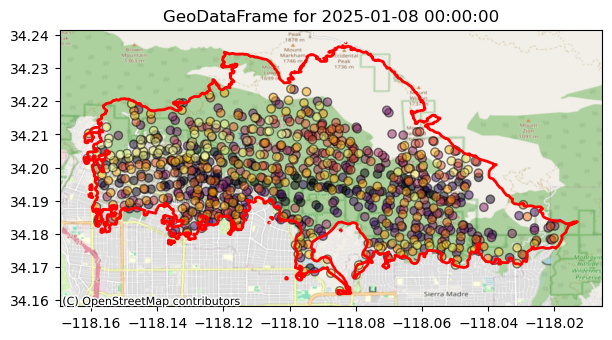

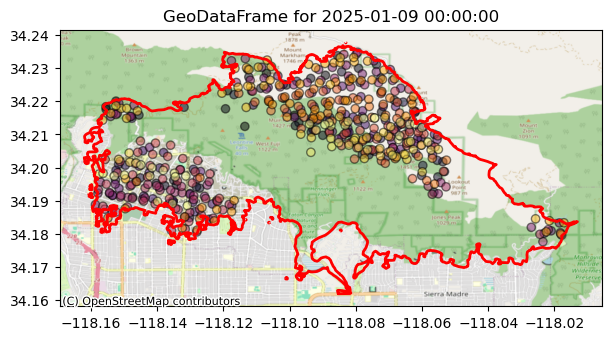

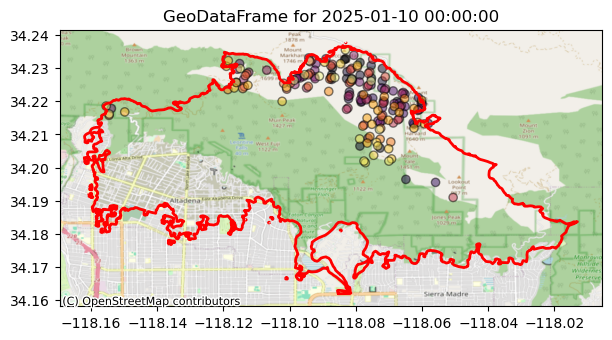

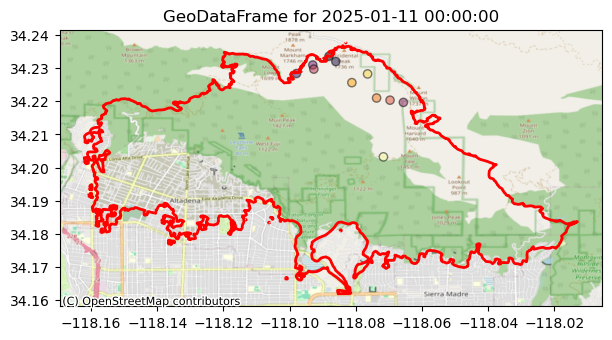

In [92]:
unique_dates = merged_eaton_gdf['ACQ_DATE'].unique()

# Loop through each unique date and plot
for date in unique_dates:
    day_data = merged_eaton_gdf[merged_eaton_gdf['ACQ_DATE'] == date]
    
    # Plot the data for this specific date
    fig, ax = plt.subplots(figsize=(7, 5))
    day_data.plot(ax=ax, c=day_data.FRP, cmap='inferno',edgecolor="black", alpha=0.5)
    gpd.GeoSeries(fire_perimeter.geometry.iloc[0]).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
    )
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)

    sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=day_data['FRP'].min(), vmax=day_data['FRP'].max()))
    sm.set_array([])  # Empty array for colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='FRP (Fire Radiative Power)')

    
    ax.set_title(f"GeoDataFrame for {date}")
    plt.show()


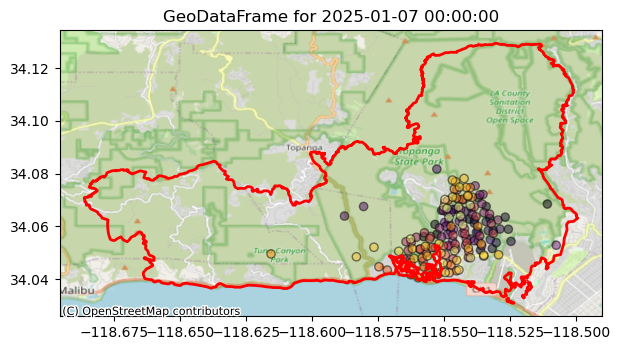

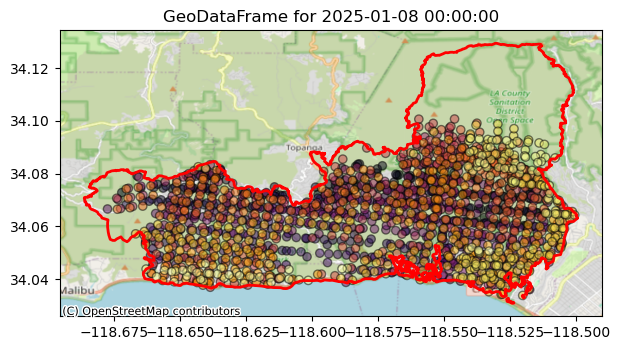

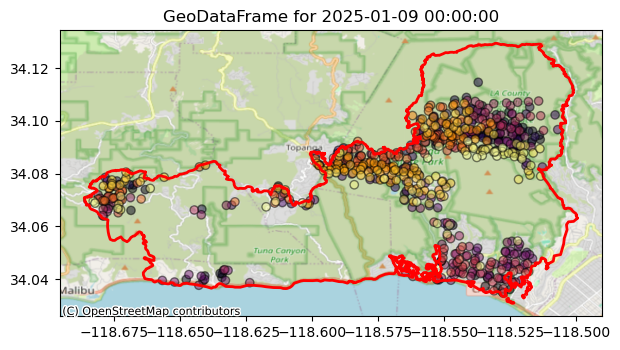

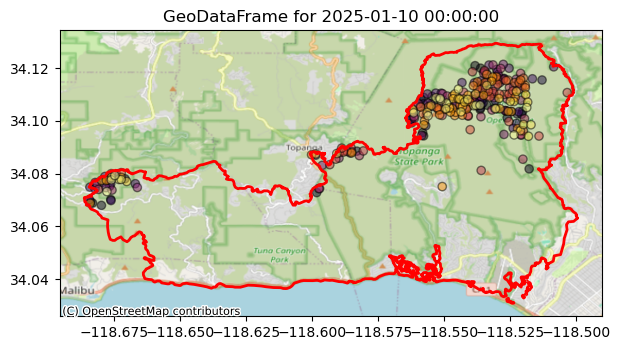

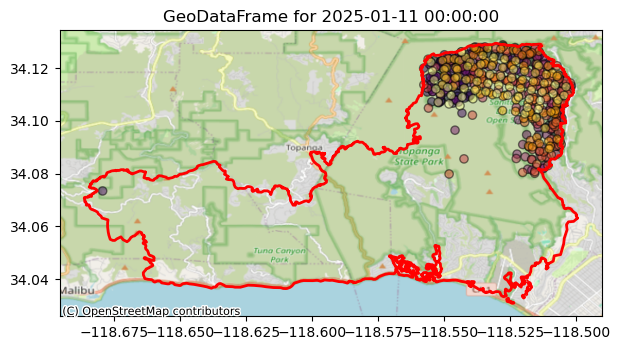

In [93]:
unique_dates = merged_palisades_gdf['ACQ_DATE'].unique()

# Loop through each unique date and plot
for date in unique_dates:
    day_data = merged_palisades_gdf[merged_palisades_gdf['ACQ_DATE'] == date]
    
    # Plot the data for this specific date
    fig, ax = plt.subplots(figsize=(7, 5))
    day_data.plot(ax=ax, c=day_data.FRP, cmap='inferno',edgecolor="black", alpha=0.5)
    gpd.GeoSeries(fire_perimeter.geometry.iloc[1]).plot(
    ax=ax, edgecolor="red", facecolor="none", linewidth=2
    )
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=fire_perimeter.crs)
    
    ax.set_title(f"GeoDataFrame for {date}")
    plt.show()
